#### Name- Chandan Upadhyay
#### Matriculation- 23197986
#### ID- yd53ybix

## Dependencies

The following libraries are required for this notebook:

- **pandas**: For data manipulation and analysis.
- **os**: For interacting with the operating system, such as file and directory management.
- **scipy.stats**: For statistical tests, including the Mann-Whitney U test.
- **statsmodels.stats.multitest**: For multiple testing corrections.
- **numpy**: For numerical computations and array operations.
- **matplotlib.pyplot**: For plotting and data visualization.
- **seaborn**: For statistical data visualization, built on top of Matplotlib.
- **gseapy**: For Gene Set Enrichment Analysis (GSEA) and interaction with biological databases.
- **gseapy.plot**: For creating plots specifically related to GSEA results.


In [55]:
import pandas as pd
import os
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy as gp
from gseapy import Biomart
from statsmodels.stats.multitest import multipletests
from gseapy.plot import barplot, dotplot
from adjustText import adjust_text


In [56]:
#from google.colab import files
#uploaded = files.upload()

**STEP 1**
------------------------------------

### Load and Filter Data

1. **Loading Data:**
   - loaded the gene expression and phenotype datasets into pandas DataFrame objects. The sample IDs were used as indices, and the gene IDs were used as columns. If the data was not initially in this format, it was transposed it to ensure the correct orientation.
    Gene Expression- https://xenabrowser.net/datapages/?dataset=TCGA-LUAD.star_fpkm.tsv&host=https%3A%2F%2Fgdc.xenahubs.net&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443

    Phenotype- https://xenabrowser.net/datapages/?dataset=TCGA-LUAD.clinical.tsv&host=https%3A%2F%2Fgdc.xenahubs.net&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443

2. **Partitioning Data by Sample Type:**
   - Using the phenotype DataFrame, partitioned the gene expression data into two separate DataFrames:
     - **Primary Tumor Samples:** DataFrame containing only the data for samples classified as 'Primary Tumor'.
     - **Healthy Tissue Samples:** DataFrame containing only the data for samples classified as 'Solid Tissue Normal'.
   - The necessary information for this partitioning was obtained from the `sample_type.samples` column in the phenotype data, as detailed in the referenced paper.

3. **Verification and Validation:**
   - Verified the presence of the necessary columns in the gene expression DataFrame and filtered out any samples not present in both the gene expression and phenotype DataFrames to ensure data consistency.


In [57]:
current_directory = os.getcwd()
geneexp = os.path.join(current_directory, 'TCGA-LUAD.star_fpkm.tsv.gz')
phenotype = os.path.join(current_directory, 'TCGA-LUAD.clinical.tsv.gz')

df_geneexp = pd.read_csv(geneexp, compression='gzip', delimiter='\t', index_col=0)
df_phenotype = pd.read_csv(phenotype, compression='gzip', delimiter='\t', index_col=0)


In [58]:
"""

print(df_geneexp.shape)
print(df_phenotype.shape)
print(df_geneexp.columns)
print(df_geneexp.describe())
"""

'\n\nprint(df_geneexp.shape)\nprint(df_phenotype.shape)\nprint(df_geneexp.columns)\nprint(df_geneexp.describe())\n'

In [59]:
value_counts = df_phenotype['sample_type.samples'].value_counts(dropna=False)
print(value_counts)

sample_type.samples
Primary Tumor          595
Solid Tissue Normal    120
FFPE Scrolls             4
Recurrent Tumor          2
Name: count, dtype: int64


In [60]:
# Split df_phenotype into primary tumor and healthy tissue
primary_tumor_genes = df_phenotype[df_phenotype['sample_type.samples'] == 'Primary Tumor']
healthy_tissue_genes = df_phenotype[df_phenotype['sample_type.samples'] == 'Solid Tissue Normal']

primary_tumor_columns = primary_tumor_genes.index.tolist()
healthy_tissue_columns = healthy_tissue_genes.index.tolist()

primary_tumor_columns = [col for col in primary_tumor_columns if col in df_geneexp.columns]
healthy_tissue_columns = [col for col in healthy_tissue_columns if col in df_geneexp.columns]

# Filter columns in df_geneexp to get primary tumor and healthy tissue dataframes
primary_tumor = df_geneexp[primary_tumor_columns]
healthy_tissue = df_geneexp[healthy_tissue_columns]

**STEP 2**
------------------------------------

### Differential Gene Expression Analysis

1. **Data Preprocessing:**
   - **Ensure Matching Indices:**
     - Ensured that the indices (gene identifiers) in the primary tumor and healthy tissue DataFrames matched by intersecting their indices.
   - **Remove NaN Values:**
     - Dropped rows with all NaN values in both DataFrames to clean the data before analysis.

2. **Differential Expression Testing:**
   - **Mann-Whitney U Test:**
     - Applied the Mann-Whitney U test to compare the expression levels of each gene between primary tumor and healthy tissue samples. This test is used to identify genes that are differentially expressed.
   - **Collecting Results:**
     - For each gene, recorded the test statistic and the P-value, storing these in a list of dictionaries.

3. **Multiple Testing Correction:**
   - **P-Value Adjustment:**
     - Corrected for multiple testing using the Benjamini-Hochberg procedure, a method provided by the statsmodels package, to control the false discovery rate (FDR). Adjusted P-values were added to the results DataFrame.

4. **Log2 Fold Change Calculation:**
   - **Mean Expression Levels:**
     - Calculated the mean expression levels for each gene in the primary tumor and healthy tissue samples.
   - **Handling Zeros:**
     - To avoid division by zero errors, replaced any zero values in the healthy tissue means with NaN.
   - **Compute Log2 Fold Change:**
     - Computed the log2 fold change for each gene, comparing the expression levels between primary tumor and healthy tissue samples. This metric helps in quantifying the change in gene expression.

5. **Finalizing Results:**
   - **Creating the Results DataFrame:**
     - Created a pandas DataFrame that includes the gene identifier, the P-value from the Mann-Whitney U test, the adjusted P-value from the multiple testing correction, and the log2 fold change.
   - **Exporting to CSV:**
     - Finally, wrote the results to a CSV file named `differential_results.csv`, ensuring that the findings are saved for further analysis or reporting.


In [61]:
primary_tumor = primary_tumor.loc[primary_tumor.index.intersection(healthy_tissue.index)]
healthy_tissue = healthy_tissue.loc[healthy_tissue.index.intersection(primary_tumor.index)]

#Drop rows with NaN values in both dataframes
primary_tumor = primary_tumor.dropna(how='all')
healthy_tissue = healthy_tissue.dropna(how='all')

#Perform the Mann-Whitney U test for each gene
results = []
for gene in primary_tumor.index:
    primary_values = primary_tumor.loc[gene]
    healthy_values = healthy_tissue.loc[gene]

    _, p_value = mannwhitneyu(primary_values, healthy_values)
    results.append({'gene': gene, 'p_value': p_value})

results_df = pd.DataFrame(results)

In [62]:
# Correct for multiple testing for adjusted p-values
p_values = results_df['p_value'].values
_, adjusted_p_values, _, _ = multipletests(p_values, method='fdr_bh',returnsorted=True)

results_df['adjusted_p_value'] = adjusted_p_values


In [63]:
mean_primary_tumor = primary_tumor.mean(axis=1)
mean_healthy_tissue = healthy_tissue.mean(axis=1)
e = 1e-6
mean_primary_tumor += e
mean_healthy_tissue += e

# Compute the log2 fold change for each gene
log2_fold_change = np.log2(mean_primary_tumor / mean_healthy_tissue)

results_df = results_df.set_index('gene')
results_df['log2_fold_change'] = log2_fold_change
results_df = results_df.reset_index()


# Write the results to a CSV file
results_df = results_df[['gene', 'p_value', 'adjusted_p_value', 'log2_fold_change']]
results_df.to_csv('differential_results.csv', index=False)


**STEP 3**
------------------------------------

### Generate a Volcano Plot

1. **Transform P-values for Plotting:**
   - **Convert P-values:**
     - Converted the adjusted P-values from Step 2 to their negative logarithm base 10 (-log10) for better visualization on the volcano plot. This transformation helps in emphasizing small P-values, making significant genes stand out.

2. **Identify Top Genes:**
   - **Top 10 Genes by P-value:**
     - Sorted the DataFrame by the adjusted P-value and selected the top 10 genes with the smallest adjusted P-values. These genes are considered the most significantly differentially expressed between primary tumor and healthy tissue samples.

3. **Creating the Volcano Plot:**
   - **Plot Setup:**
     - Set up the plot with Matplotlib and Seaborn, using 'log2_fold_change' for the x-axis and '-log10_p_value' for the y-axis. The general distribution of genes was plotted in grey, providing a baseline visualization.
   - **Highlighting Top Genes:**
     - The top 10 genes with the smallest P-values were highlighted in red to distinguish them from the rest of the genes.
   - **Annotating Top Genes:**
     - Annotated the top genes with their gene IDs, using arrows to point from the dots to the text labels. This was done by calculating positions around a circle for even distribution of labels.

4. **Finalizing the Plot:**
   - **Labeling and Titles:**
     - Added axis labels ("Log2 Fold Change" and "-Log10 P-value") and a title ("Volcano Plot of Differential Gene Expression") to the plot for clarity.
   - **Saving and Displaying:**
     - The plot was saved as a PDF file named `volcano_plot.pdf` for high-quality output suitable for publication or reporting. The plot was also displayed within the environment.

This volcano plot visually represents the differential gene expression analysis, highlighting the most significantly altered genes between primary tumor and healthy tissue samples.


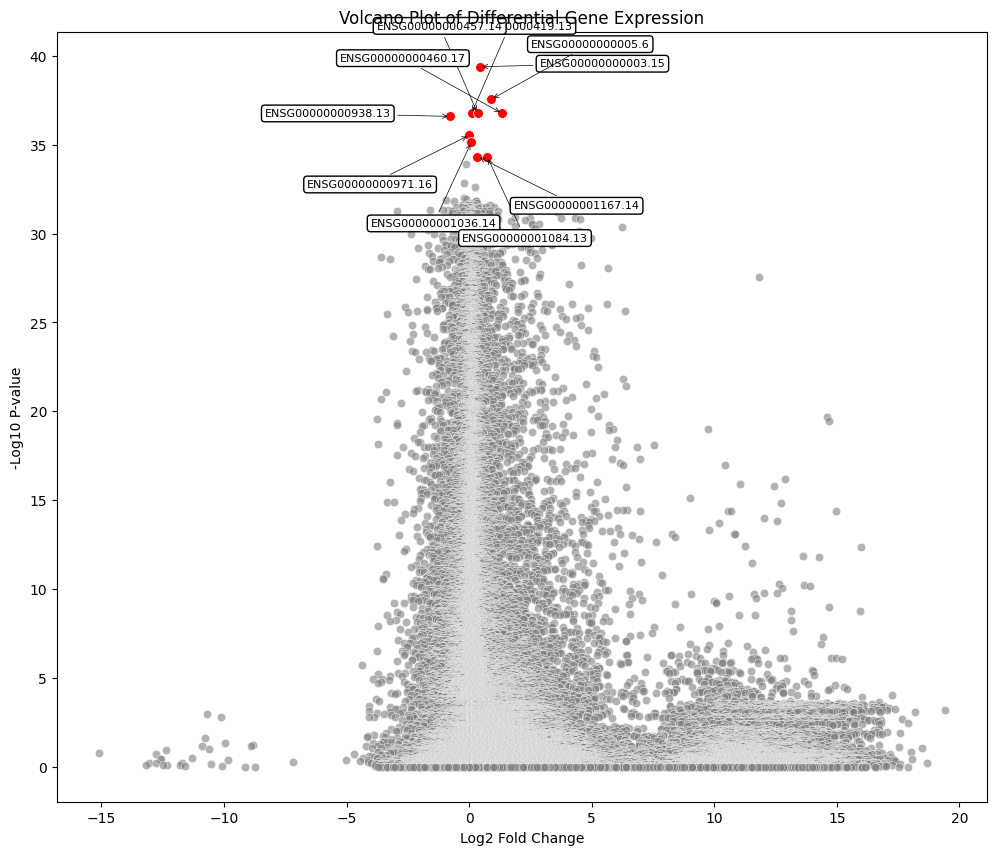

In [64]:
# Convert p-values to -log10(p-values) to create a volcano plot
results_df['-log10_p_value'] = -np.log10(results_df['adjusted_p_value'])

top = results_df.nsmallest(10, 'adjusted_p_value')

# Create the volcano plot
plt.figure(figsize=(12, 10))
sns.scatterplot(data=results_df, x='log2_fold_change', y='-log10_p_value', color='grey', alpha=0.6)
sns.scatterplot(data=top, x='log2_fold_change', y='-log10_p_value', color='red', s=50)

angles = np.linspace(0, 2 * np.pi, len(top), endpoint=False)
for i, angle in enumerate(angles):
    x = top['log2_fold_change'].iloc[i]
    y = top['-log10_p_value'].iloc[i]
    label = top['gene'].iloc[i]

    x_text = x + 5 * np.cos(angle)
    y_text = y + 5 * np.sin(angle)
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(x_text, y_text),
        arrowprops=dict(facecolor='black', arrowstyle="->", lw=0.5),
        ha='center', fontsize=8, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
    )
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 P-value')
plt.title('Volcano Plot of Differential Gene Expression')

# Save the plot to a PDF file
plt.savefig('volcano_plot.pdf')

# Show the plot
plt.show()


**STEP 4**
------------------------------------

### Gene Set Enrichment Analysis (GSEA)

1. **Mapping Ensembl IDs to Gene Names:**
   - **Initialize Biomart Server:**
     - Used GSEApy's Biomart API to access a database of biological datasets.
   - **Prepare Gene List:**
     - For the 10 genes identified in Step 3, removed the version numbers from the Ensembl gene IDs to match the format required by the Biomart API.

2. **Querying Biomart for Gene Names:**
   - **Query Setup:**
     - Set up a query to map the Ensembl gene IDs (without version numbers) to their corresponding gene names.
   - **Execute Query:**
     - The query was executed using Biomart, and the resulting mapping was stored in a DataFrame.

3. **Performing Gene Set Enrichment Analysis (GSEA):**
   - **Library Names:**
     - Confirmed the availability of various gene set libraries for human pathways, including GO Molecular Function, KEGG, GO Biological Process, and GO Cellular Component.
   - **Run Enrichment Analysis:**
     - Ran the Enrichr tool on the mapped gene names to find significantly enriched pathways in the top gene sets. This analysis helps identify biological functions and processes that are overrepresented among the top differentially expressed genes.

4. **Plotting Enrichment Results:**
   - **Barplot of Top Enrichments:**
     - Using GSEApy's barplot function, visualized the top enrichment results, highlighting significant pathways.
   - **Dotplot Visualization:**
     - Additionally, generated a dotplot to provide a different visual representation of the enrichment results, using the 'viridis_r' colormap for better visual distinction.

These steps help to understand the biological significance of the differentially expressed genes by identifying enriched pathways and processes.


In [65]:
# Make a clone of the dataframe
top_genes1 = top.copy()

# Remove version numbers from Ensembl IDs
top_genes1['gene'] = top_genes1['gene'].str.split('.').str[0]

bm = gp.Biomart()
queries = {'ensembl_gene_id': top_genes1['gene'].tolist()}

results1 = bm.query(dataset='hsapiens_gene_ensembl',
                    attributes=['ensembl_gene_id', 'external_gene_name'],
                    filters=queries)

In [66]:
names = gp.get_library_name(organism='Human')
#print(names)

In [67]:
glist= results1['external_gene_name'].dropna().squeeze().str.strip().tolist()
enr = gp.enrichr(gene_list=glist,
                 gene_sets=['GO_Molecular_Function_2023', 'KEGG_2021_Human', 'GO_Biological_Process_2023', 'GO_Cellular_Component_2023'],
                 organism='Human'
                )

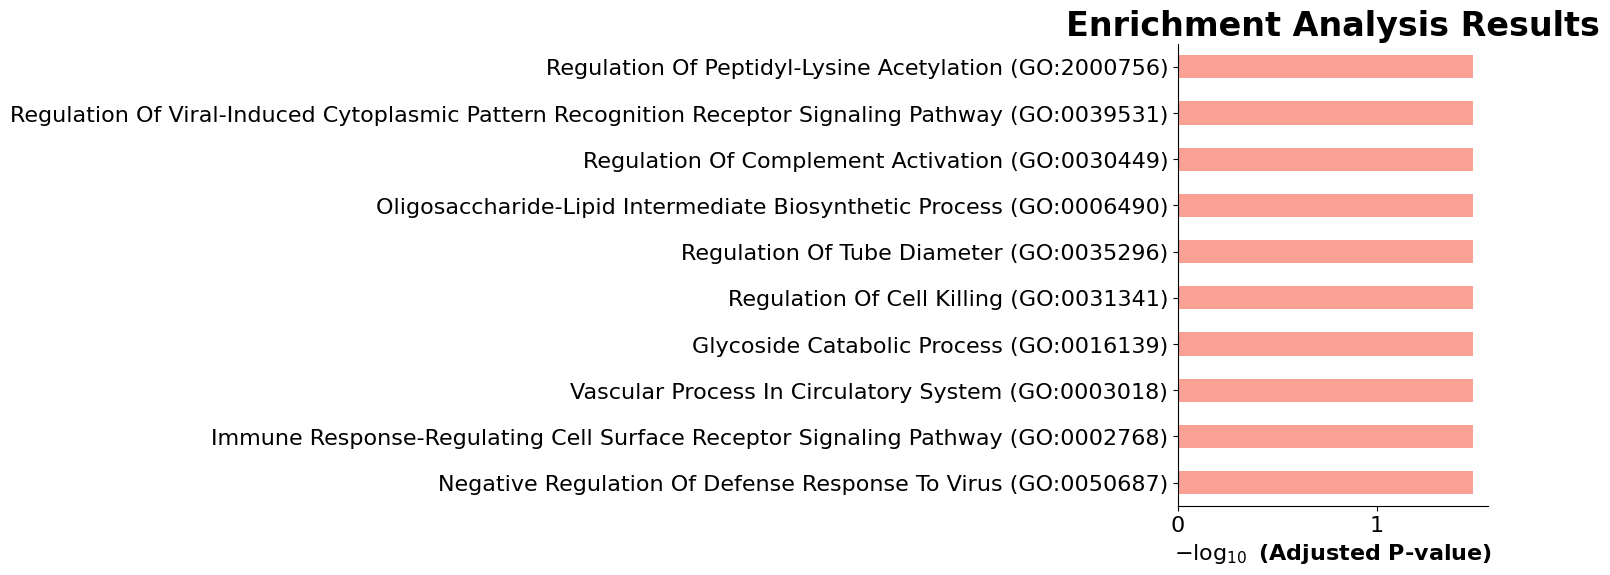

In [68]:
# Use GSEApy's barplot function to plot the top enrichment results
barplot(enr.results,title='Enrichment Analysis Results',)
plt.show()

<Axes: title={'center': 'Enrichment Analysis Results'}, xlabel='Combined Score'>

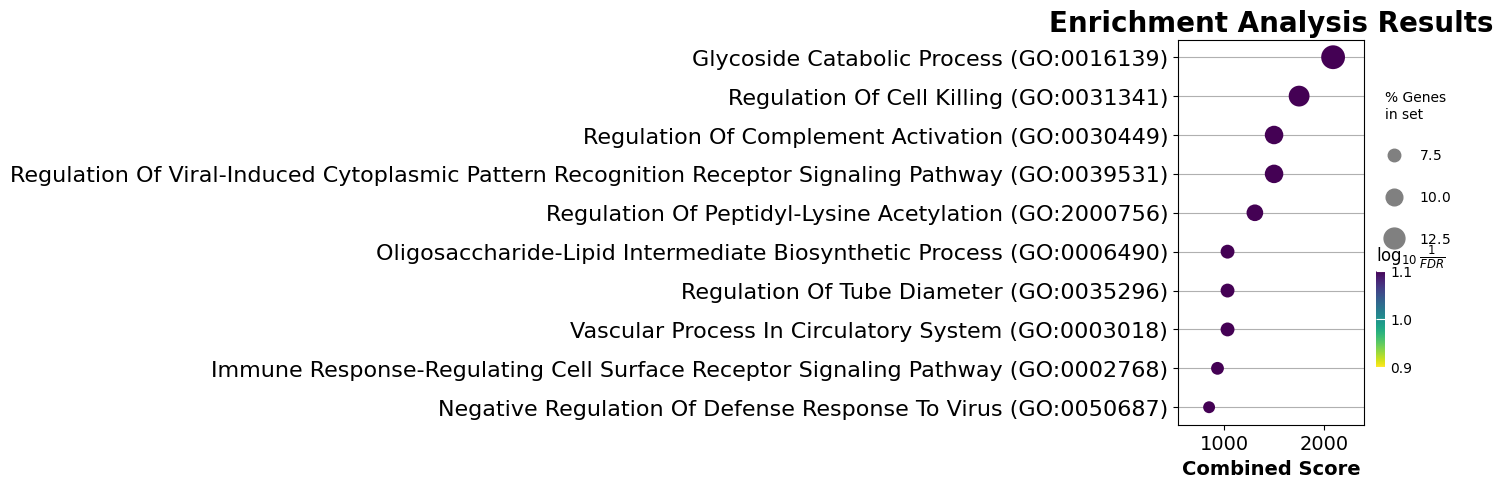

In [69]:
dotplot(enr.results, title='Enrichment Analysis Results',cmap='viridis_r',size=20, figsize=(3,5))

**STEP 5**
------------------------------------

### Choice of Variable: `cigarettes_per_day.exposures`

#### Justification:

1. Biological Significance:
Cigarette smoking is the most significant environmental risk factor for lung cancer. It directly affects gene expression, DNA methylation, and mutation burden. This variable reflects chronic exposure to tobacco, making it critical for understanding the biology of lung tumorigenesis.

2. Relevance to Disease Mechanisms:
Smoking introduces carcinogens that: Mutate oncogenes and tumor suppressor genes (e.g., TP53, KRAS) Induce inflammation and oxidative stress Alter gene regulatory networks, especially in bronchial epithelial cells Differential gene expression analysis between non-smokers, light smokers, and heavy smokers can uncover key molecular signatures linked to smoking-induced lung carcinogenesis.

3. Impact on Treatment and Management:
Smokers often respond differently to immunotherapies and chemotherapies (e.g., PD-L1 expression and TMB tend to be higher in smokers) Identifying smoking-related gene expression signatures can guide treatment stratification and prognosis may also inform lung cancer screening protocols



In [70]:
current_directory = os.getcwd()
geneexp = os.path.join(current_directory, 'TCGA-LUAD.star_fpkm.tsv.gz')
phenotype = os.path.join(current_directory, 'TCGA-LUAD.clinical.tsv.gz')

df_geneexp = pd.read_csv(geneexp, compression='gzip', delimiter='\t', index_col=0)
df_phenotype = pd.read_csv(phenotype, compression='gzip', delimiter='\t', index_col=0)

In [71]:
value_counts = df_phenotype['cigarettes_per_day.exposures'].value_counts(dropna=False)
print(value_counts)

cigarettes_per_day.exposures
NaN         278
2.191781     42
2.739726     42
1.095890     39
1.643836     38
           ... 
1.808219      1
0.246575      1
8.054795      1
2.219178      1
8.438356      1
Name: count, Length: 95, dtype: int64


**STEP 1**
------------------------------------

## Load and Filter Data by Smoking Intensity
## Handling Missing Data:
To ensure the accuracy and reliability of the analysis, samples with missing values in the cigarettes_per_day.exposures column were excluded. This filtering step retains only those samples with reported cigarette consumption data, forming a clean dataset for downstream analysis.

## Defining Smoking Intensity Groups:
The filtered dataset was split into two groups based on smoking intensity:
Low Smokers: Individuals who reported smoking less than or equal to the median number of cigarettes per day.
High Smokers: Individuals who reported smoking more than the median number of cigarettes per day.

The median value was computed dynamically from the non-missing data to ensure an unbiased and balanced split of the population.

## Sample ID Matching and Validation:
To ensure data consistency, only sample IDs that were present in both the phenotype dataset and the gene expression dataset were retained. This prevents alignment issues during analysis and ensures that only samples with complete phenotype and expression data are included.

Subsetting Gene Expression Data:
Using the filtered lists of sample IDs, the gene expression DataFrame was partitioned into two new DataFrames:

low_df: Contains gene expression data for low smokers.
high_df: Contains gene expression data for high smokers.




In [72]:
non_nan = df_phenotype.dropna(subset=['cigarettes_per_day.exposures'])

# Split into low/high smokers using median threshold
median_value = non_nan['cigarettes_per_day.exposures'].median()
print(f"Median cigarettes/day: {median_value}")

# Get sample IDs from index that match gene expression columns
low_samples = non_nan.index[non_nan['cigarettes_per_day.exposures'] <= median_value].tolist()
high_samples = non_nan.index[non_nan['cigarettes_per_day.exposures'] > median_value].tolist()

# Filter samples to those present in gene expression data
low_samples = [s for s in low_samples if s in df_geneexp.columns]
high_samples = [s for s in high_samples if s in df_geneexp.columns]

print(f"Low smokers samples: {len(low_samples)}")
print(f"High smokers samples: {len(high_samples)}")

# Subset gene expression data
low_df = df_geneexp[low_samples]
high_df = df_geneexp[high_samples]


Median cigarettes/day: 2.191780821917808
Low smokers samples: 233
High smokers samples: 161


In [73]:
low_df = low_df.loc[low_df.index.intersection(high_df.index)]
high_df = high_df.loc[high_df.index.intersection(low_df.index)]

**STEP 2**
------------------------------------

### Statistical Analysis: Smoking-Associated Differential Gene Expression

**Mann-Whitney U Test:**
To identify genes differentially expressed between high and low smokers, a Mann-Whitney U test was performed for each gene. Expression values were extracted from the `high_df` and `low_df` DataFrames, and missing values were excluded to ensure valid comparisons.

**Multiple Testing Correction:**
P-values were adjusted using the Benjamini-Hochberg False Discovery Rate (FDR) method to control for multiple comparisons.

**Log2 Fold Change Calculation:**
Mean expression levels for each gene were computed in both groups. A small constant (epsilon) was added to prevent division by zero, and log2 fold change was calculated to quantify expression differences.

**Result Compilation:**
The final DataFrame included gene names, raw and adjusted p-values, and log2 fold changes. Results were saved as `differential_expression_smoking_results.csv`.

This analysis highlights genes potentially influenced by smoking intensity.


In [74]:
smoking_results = []

#Perform the Mann-Whitney U test for each gene
results = []
for gene in high_df.index:
    high_values = high_df.loc[gene]
    low_values = low_df.loc[gene]

    _, p_value = mannwhitneyu(high_values, low_values)
    smoking_results.append({'gene': gene, 'p_value': p_value})

smoking_results_df = pd.DataFrame(smoking_results)

In [75]:
# Adjust p-values using FDR (Benjamini-Hochberg)
p_values = smoking_results_df['p_value'].values
_, adjusted_p_values, _, _ = multipletests(p_values, method='fdr_bh')

# Add adjusted p-values to DataFrame
smoking_results_df['adjusted_p_value'] = adjusted_p_values  # <-- Fix variable name here

In [76]:
mean_high_smokers = high_df.mean(axis=1)
mean_low_smokers = low_df.mean(axis=1)
e = 1e-6
mean_high_smokers += e
mean_low_smokers += e

# Compute the log2 fold change for each gene
log2_fold_change = np.log2(mean_high_smokers / mean_low_smokers)

smoking_results_df = smoking_results_df.set_index('gene')
smoking_results_df['log2_fold_change'] = log2_fold_change
smoking_results_df = smoking_results_df.reset_index()


# Write the results to a CSV file
smoking_results_df = smoking_results_df[['gene', 'p_value', 'adjusted_p_value', 'log2_fold_change']]
smoking_results_df.to_csv('differential_expression_smoking_results.csv', index=False)

display(smoking_results_df)

,gene,p_value,adjusted_p_value,log2_fold_change
0,ENSG00000000003.15,0.592962,0.976300,0.018577
1,ENSG00000000005.6,0.246528,0.855949,-0.428439
2,ENSG00000000419.13,0.220657,0.852208,0.013899
3,ENSG00000000457.14,0.123073,0.820733,-0.068356
4,ENSG00000000460.17,0.315883,0.899913,0.047750
...,...,...,...,...
60655,ENSG00000288669.1,0.429403,0.921921,-0.111675
60656,ENSG00000288670.1,0.655989,0.994310,-0.031931
60657,ENSG00000288671.1,1.000000,1.000000,0.000000
60658,ENSG00000288674.1,0.244397,0.855080,-0.093911


**STEP 3**
------------------------------------

Here's a concise, academically styled description of your volcano plot generation process based on your code:

---

### Volcano Plot Generation: Differential Expression in Smokers

**P-value Transformation:**
Adjusted p-values were transformed to $-\log_{10}(\text{p-value})$ to enhance visualization of statistical significance in the volcano plot.

**Top Gene Selection:**
The top 10 genes with the smallest adjusted p-values were identified as the most significantly differentially expressed between high and low smokers.

**Plot Construction:**
A volcano plot was created using log2 fold change (x-axis) and $-\log_{10}$ adjusted p-values (y-axis). All genes were plotted in grey, while the top 10 were highlighted in red for emphasis.

**Annotation and Output:**
Top genes were annotated with gene labels using directional arrows. The final plot was labeled appropriately and saved as a high-resolution PDF (`volcano_plot_part5.pdf`), suitable for reporting or publication.


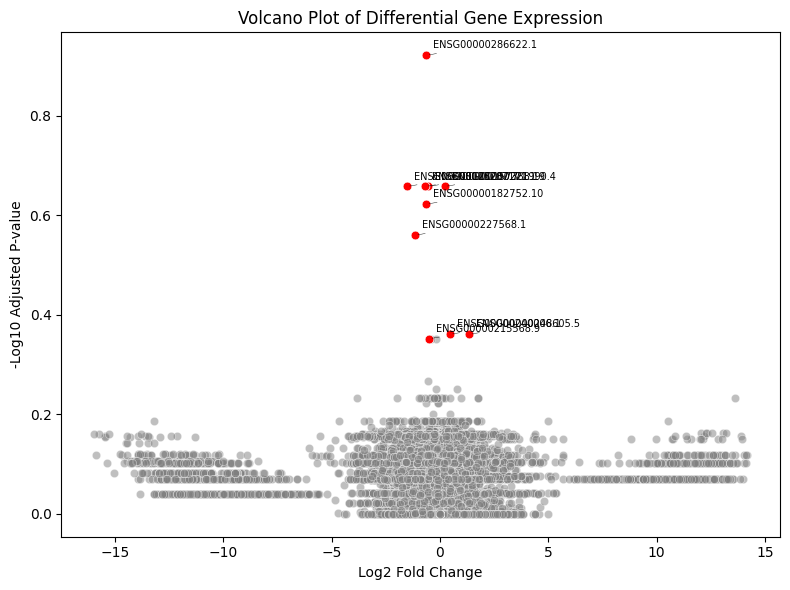

In [77]:
# Compute -log10 adjusted p-values for visualization
smoking_results_df['-log10_p_value'] = -np.log10(smoking_results_df['adjusted_p_value'])

# Identify the top 10 most significant genes based on adjusted p-value
top_genes = smoking_results_df.nsmallest(10, 'adjusted_p_value')

# Initialize the matplotlib figure with adjusted dimensions for compactness
plt.figure(figsize=(8, 6))

# Plot all genes in grey to visualize the overall distribution
sns.scatterplot(
    data=smoking_results_df,
    x='log2_fold_change',
    y='-log10_p_value',
    color='grey',
    alpha=0.5
)

# Highlight the top differentially expressed genes in red
sns.scatterplot(
    data=top_genes,
    x='log2_fold_change',
    y='-log10_p_value',
    color='red',
    s=40
)

# Annotate the top genes with their gene names using offset labeling
for _, row in top_genes.iterrows():
    plt.annotate(
        row['gene'],
        xy=(row['log2_fold_change'], row['-log10_p_value']),
        xytext=(5, 5),
        textcoords='offset points',
        ha='left',
        fontsize=7,
        arrowprops=dict(arrowstyle='-', linewidth=0.3)
    )

# Set axis labels and plot title
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 Adjusted P-value')
plt.title('Volcano Plot of Differential Gene Expression')

# Optimize layout and export the plot
plt.tight_layout()
plt.savefig('volcano_plot_part5.pdf')
plt.show()


**STEP 4**
------------------------------------

### Gene Enrichment Analysis and Visualization

#### Data Preparation:
1. **Cloning and Cleaning the Data**:
   - A clone of the top 10 differentially expressed genes dataframe (`top`) was created to preserve the original data.
   - Ensembl IDs in the 'gene' column were cleaned by removing version numbers, ensuring compatibility with gene name mapping tools.

2. **Gene Name Mapping**:
   - The `gp.Biomart` API was used to map Ensembl IDs to external gene names. This step involved querying the Ensembl database for the corresponding gene names based on the cleaned Ensembl IDs.

#### Gene Enrichment Analysis:
1. **Gene List Extraction**:
   - The list of external gene names was extracted from the mapping results and prepared for enrichment analysis. This list represents the top differentially expressed genes without version numbers.

2. **Enrichment Analysis Execution**:
   - The `gp.enrichr` function was employed to perform gene set enrichment analysis (GSEA) using the gene list. The analysis was conducted across several gene sets, including:
     - **GO_Molecular_Function_2023**
     - **KEGG_2021_Human**
     - **GO_Biological_Process_2023**
     - **GO_Cellular_Component_2023**
   - The organism was specified as 'Human' to ensure accurate gene set matching.

#### Visualization:
1. **Bar Plot of Enrichment Results**:
   - The enrichment results were visualized using GSEApy's `barplot` function, providing a quick overview of the most significantly enriched pathways and functions.

2. **Dot Plot of Enrichment Results**:
   - Additionally, a dot plot was generated using the `dotplot` function, which visually represents the enrichment scores and the significance of the enriched pathways. The plot utilized a 'viridis_r' colormap and specified plot dimensions for clarity.

3. **Final Adjustments and Display**:
   - The plots were customized with appropriate titles, and adjustments were made to ensure clarity and readability. The bar plot and dot plot provide complementary views of the enrichment results, highlighting key pathways and biological processes associated with the top differentially expressed genes.



In [83]:
# Make a clone of the dataframe
top1 = top_genes.copy()

# Remove version numbers from Ensembl IDs
top1['gene'] = top1['gene'].str.split('.').str[0]

bm = gp.Biomart()
queries = {'ensembl_gene_id': top1['gene'].tolist()}  # Need to be a dict object

resultsneo = bm.query(dataset='hsapiens_gene_ensembl',
                    attributes=['ensembl_gene_id', 'external_gene_name'],
                    filters=queries)

glist= resultsneo['external_gene_name'].dropna().squeeze().str.strip().tolist()

#Perform Gene Enrichment Analysis
enr = gp.enrichr(gene_list=glist,
                 gene_sets=['GO_Molecular_Function_2023', 'KEGG_2021_Human', 'GO_Biological_Process_2023', 'GO_Cellular_Component_2023'],
                 organism='Human'
                )


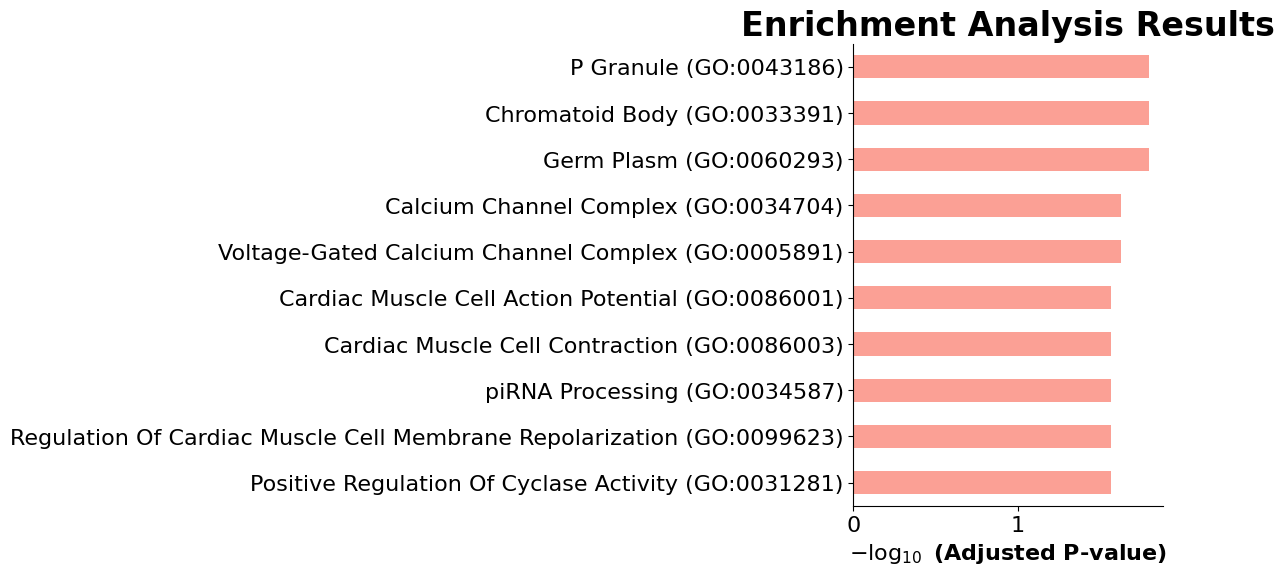

In [84]:
# Use GSEApy's barplot function to plot the top enrichment results
barplot(enr.results,title='Enrichment Analysis Results',)
plt.show()

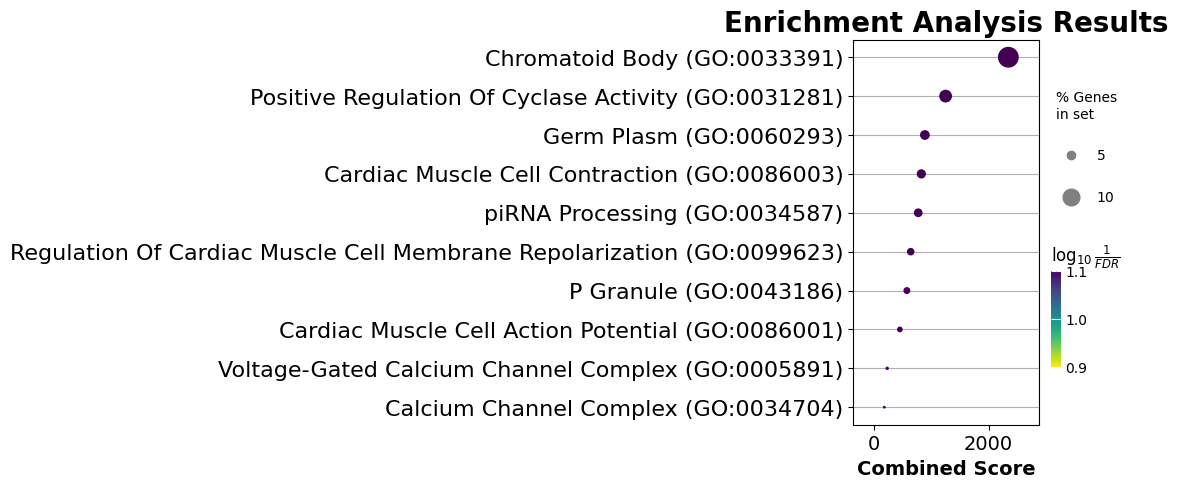

In [85]:
ax= dotplot(enr.results, title='Enrichment Analysis Results',cmap='viridis_r', size=20, figsize=(3,5))